In [1]:
from geopy.distance import distance
import geopy
import zipfile
from geopy.geocoders import Nominatim
import datetime as dt
from typing import Union
from pathlib import Path
import rasterio
import numpy as np
import requests
import geemap
import os
from io import BytesIO
import matplotlib.pyplot as plt
import math
import ee
from PIL import Image
import rasterio.transform
import sys
from contextlib import contextmanager
from tqdm import tqdm
from divide_data import divide_images
from data_loader import train_val_test_loader

In [2]:
from data_loader import train_val_test_loader
tr, val, test = train_val_test_loader(
    'data',
    scale=4,
    batch_size=1,
    mode='train_val_test'
)


In [14]:
next(iter(tr))

{'lr': tensor([[[[-0.9451, -0.9373, -0.9373,  ..., -0.7882, -0.8196, -0.8353],
           [-0.9451, -0.9373, -0.9373,  ..., -0.7961, -0.8275, -0.8510],
           [-0.9294, -0.9294, -0.9294,  ..., -0.8039, -0.8431, -0.8588],
           ...,
           [-0.8431, -0.8353, -0.8353,  ..., -0.8039, -0.7961, -0.7961],
           [-0.8353, -0.8353, -0.8353,  ..., -0.8275, -0.8275, -0.8275],
           [-0.8353, -0.8353, -0.8353,  ..., -0.8275, -0.8275, -0.8275]],
 
          [[-0.8980, -0.9059, -0.9059,  ..., -0.7569, -0.7725, -0.7882],
           [-0.8980, -0.9059, -0.9059,  ..., -0.7647, -0.7804, -0.7961],
           [-0.8824, -0.8902, -0.8980,  ..., -0.7725, -0.7882, -0.8039],
           ...,
           [-0.7569, -0.7490, -0.7490,  ..., -0.7255, -0.7255, -0.7176],
           [-0.7569, -0.7490, -0.7490,  ..., -0.7412, -0.7412, -0.7412],
           [-0.7569, -0.7490, -0.7490,  ..., -0.7412, -0.7412, -0.7412]],
 
          [[-0.9373, -0.9451, -0.9451,  ..., -0.8510, -0.8667, -0.8745],
       

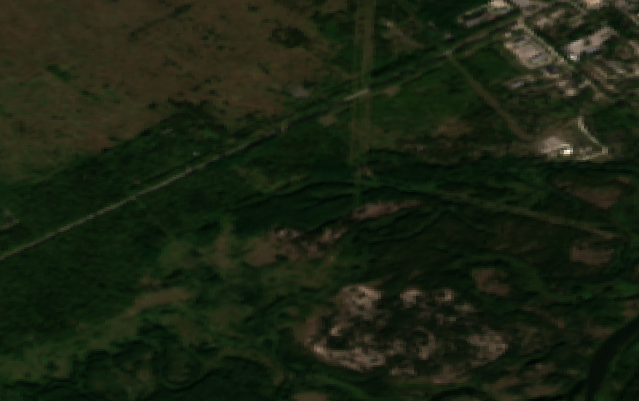

In [14]:
with rasterio.open('data/train/' + 'random_places_9_0.tif') as src:
            img = src.read()
            meta = src.meta
            bands = src.descriptions
img = (img - img.min()) / (img.max() - img.min()) * 255
img = img.astype(np.uint8)
img.transpose(1, 2, 0).shape
img = Image.fromarray(img.transpose(1, 2, 0))
if img.mode != "RGB":
    img_hr = img.convert("RGB")
img

In [5]:
next(iter(tr))

RasterioIOError: Caught RasterioIOError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "rasterio/_base.pyx", line 310, in rasterio._base.DatasetBase.__init__
  File "rasterio/_base.pyx", line 221, in rasterio._base.open_dataset
  File "rasterio/_err.pyx", line 359, in rasterio._err.exc_wrap_pointer
rasterio._err.CPLE_OpenFailedError: 'data/test' not recognized as being in a supported file format.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/mnt/d/Coding/Python/SatSR-Pipeline/.venv/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/Coding/Python/SatSR-Pipeline/.venv/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/Coding/Python/SatSR-Pipeline/.venv/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/mnt/d/Coding/Python/SatSR-Pipeline/data_loader.py", line 93, in __getitem__
    with rasterio.open(self.hr_dir / filename) as src:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/Coding/Python/SatSR-Pipeline/.venv/lib/python3.11/site-packages/rasterio/env.py", line 463, in wrapper
    return f(*args, **kwds)
           ^^^^^^^^^^^^^^^^
  File "/mnt/d/Coding/Python/SatSR-Pipeline/.venv/lib/python3.11/site-packages/rasterio/__init__.py", line 356, in open
    dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "rasterio/_base.pyx", line 312, in rasterio._base.DatasetBase.__init__
rasterio.errors.RasterioIOError: 'data/test' not recognized as being in a supported file format.


In [3]:
class PictureInfo:
    
    def __init__(self, 
                 meter_per_pixel: float = 5.0,
                 bands: list = ['B4', 'B3', 'B2'],
                 box: dict = {'left': 17.061038, 'bottom': 51.107157, 'right': 17.061078, 'top': 51.107157}):
        
        """
        Initialize the class with given parameters.

        Parameters
        ----------
        meter_per_pixel : float, optional
            The resolution in meters per pixel. Default is 5.0.
        bands : list, optional
            The list of bands to be used. Default is ['B4', 'B3', 'B2'].
        box : dict, optional
            The bounding box of the area with keys 'left', 'bottom', 'right', 'top'. Default is Wrocław University of Science and Technology localization.
        """
        self.box = box
        self.meter_per_pixel = meter_per_pixel
        self.bands = bands
    
    @property
    def geo_points(self):
        """
        Get the geographical points of the bounding box.

        Returns
        -------
        list of tuple
            A list of tuples representing the geographical points (longitude, latitude) of the bounding box.
        """
        return [(self.box['left'], self.box['bottom']), (self.box['left'], self.box['top']),
                (self.box['right'], self.box['top']), (self.box['right'], self.box['bottom'])]
    
    @property
    def box_tuple(self):
        """
        Get the bounding box as a tuple.

        Returns
        -------
        tuple
            A tuple representing the bounding box (left, bottom, right, top).
        """
        return (self.box['left'], self.box['bottom'], self.box['right'], self.box['top'])
    
    @property
    def box_corners(self):
        """
        Get the corners of the bounding box.

        Returns
        -------
        list of tuple
            A list of tuples representing the corners (longitude, latitude) of the bounding box.
        """
        corners = [(self.box['left'], self.box['bottom']), (self.box['right'], self.box['bottom']), 
                   (self.box['right'], self.box['top']), (self.box['left'], self.box['top'])]
        return corners
    
    @property
    def coordinates(self):
        """
        Get the coordinates of the bounding box.

        Returns
        -------
        tuple of numpy.ndarray
            A tuple containing two numpy arrays:
            - x: The x-coordinates (longitude) of the bounding box.
            - y: The y-coordinates (latitude) of the bounding box.
        """
        y, x = map(range, self.shape)
        affine_transform = rasterio.transform.from_bounds(*self.box_tuple, *self.shape)
        
        # we need to calculate 2 times in case of not square picture
        x = np.array(rasterio.transform.xy(affine_transform, [0]*len(x), x)[0]) 
        y = np.array(rasterio.transform.xy(affine_transform, y, [0]*len(y))[1])
        return x, y
  

In [14]:

class Pipeline:
    
    def __init__(self, data_path: str = 'data', bands: list = ['B4', 'B3', 'B2'], product: str = "COPERNICUS/S2_SR_HARMONIZED"):
        """
        Initialize the Pipeline_v1 class with given parameters.

        Parameters
        ----------
        data_path : str, optional
            The path to the data directory. Default is 'data'.
        bands : list, optional
            The list of bands to be used. Default is ['B4', 'B3', 'B2'] which are equivalents of red, green and blue bands for Sentinel2.
        product : str, optional
            The satellite image product for download. Default is "COPERNICUS/S2_SR_HARMONIZED".
        """
        
        ee.Authenticate()
        ee.Initialize()
        self.geolocator = Nominatim(user_agent="sr_pipeline")
        
        
        self.title = 'image_title'
        self.point = None
        self.distance_x = None
        self.distance_y = None
        self.full_box = None
        self.time_start = None
        self.time_end = None
        self.picture_info = None
        self.img_idx = None
        
        if not isinstance(data_path, str):
            raise ValueError("Path must be a string")
        else:
            self.download_path = Path(data_path)
        
        if not isinstance(bands, (list, tuple)):
            raise ValueError("Bands must be a list-like object")
        else:
            self.bands = bands
            
        if not isinstance(product, str):
            raise ValueError("Product must be a string")
        else:    
            self.product = product
    
        
    def setup_point(self, 
                    point: Union[tuple, str], 
                    title: str = 'image_title',
                    meter_per_pixel: float = 5.0,
                    distance_x: float = 1000, # in meters
                    distance_y: float = 1000, 
                    time_start: str = None, 
                    time_end: str = None,):
        """
        Set up the point of interest and related parameters.

        Parameters
        ----------
        point : Union[tuple, str]
            The geographical point of interest. Can be a tuple (latitude, longitude) or a string address.
        title : str, optional
            The title of the image. Default is 'image_title'.
        meter_per_pixel : float, optional
            The resolution in meters per pixel. Default is 5.0.
        distance_x : float, optional
            The distance in the x-direction in meters. Default is 1000.
        distance_y : float, optional
            The distance in the y-direction in meters. Default is 1000.
        time_start : str, optional
            The start time for the data in 'YYYY-MM-DD' format. Default is None.
        time_end : str, optional
            The end time for the data in 'YYYY-MM-DD' format. Default is None.
        """
        if isinstance(point, str):
            self.point = self.text2cord(point)
        elif isinstance(point, (tuple, list)) and len(point) == 2:
            self.point = geopy.point.Point(point)
        else:
            raise ValueError("Point must be a string or tuple with two values")
            
        if isinstance(title, str):
            self.title = title
        else:
            raise ValueError("Title must be a string")
                    
        if not self.is_number(distance_x):
            raise ValueError(f"distance_x must be a number")
        else:
            self.distance_x = distance_x
        
        if not self.is_number(distance_y):
            raise ValueError(f"distance_y must be a number")
        else:
            self.distance_y = distance_y
            
        self.full_box = self.create_box()
        
        if not self.is_number(meter_per_pixel):
            raise ValueError(f"meter_per_pixel must be a number")
        else:
            self.picture_info = PictureInfo(
                meter_per_pixel=meter_per_pixel,
                bands=self.bands,
                box=self.full_box
                )
        
        if time_start is None or time_end is None:
            print("Please provide time range")
        elif isinstance(time_start, str) and isinstance(time_end, str):
            self.time_start = dt.datetime.strptime(time_start, "%Y-%m-%d")
            self.time_end = dt.datetime.strptime(time_end, "%Y-%m-%d")
        elif isinstance(time_start, dt.datetime) and isinstance(time_end, dt.datetime):
            self.time_start = time_start
            self.time_end = time_end
        else:
            raise ValueError("Time range must be a string or datetime object")
        
        
            
    def text2cord(self, text: str):
        """
        Convert a text address to geographical coordinates.

        Parameters
        ----------
        text : str
            The address in text format.

        Returns
        -------
        geopy.point.Point
            A Point object with the latitude and longitude of the address.
        """
        point = self.geolocator.geocode(text)
        return geopy.point.Point([point.latitude, point.longitude])
    
    def create_box(self) -> dict:
        """
        Create a bounding box around the point of interest.

        Returns
        -------
        dict
            A dictionary representing the bounding box with keys 'left', 'right', 'top', and 'bottom'.
        """
        _distance_x = distance(meters=self.distance_x/2)
        _distance_y = distance(meters=self.distance_y/2)
        box = {
            "left": _distance_x.destination(self.point, 270).longitude,
            "right": _distance_x.destination(self.point, 90).longitude,
            "top": _distance_y.destination(self.point, 0).latitude,
            "bottom": _distance_y.destination(self.point, 180).latitude
        }
        return box
    
    def is_number(self, value) -> bool:
        """
        Check if the value is a number.
        """
        return isinstance(value, (int, float))
    
    def info(self):
        """
        Print information about the current state of the object.
        """
        print(f"Point: {self.point.longitude, self.point.latitude}"),
        print(f"Meter per pixel: {self.picture_info.meter_per_pixel}"),
        print(f"Distance x: {self.distance_x}"),
        print(f"Distance y: {self.distance_y}")
        print(f"Box: {self.full_box}")
        print(f"Time range: {self.time_start} - {self.time_end}")
        
    def plot_image(self, 
                   file_name: str, 
                   path_folder: str = 'data/',
                   brightness: float = 1):
        """
        Plot the satellite image with optional brightness adjustment.
        Parameters
        ----------
        file_name : str
            The name of the image file.
        path_folder : str, optional
            The folder path where the image file is located. Default is 'data/satsr'.
        brightness : float, optional
            The brightness adjustment factor. Default is 1.
        """
        path_folder = Path(path_folder)
        
        with rasterio.open(path_folder / file_name) as src:
            img = src.read()
            meta = src.meta
            bands = src.descriptions
            
        img = (img - img.min()) / (img.max() - img.min())
        img = img.transpose(1, 2, 0)[:, :, [0, 1, 2]]
        # print(img.max(), img.min(), img.mean())
        # # Apply brightness adjustment if needed
        img = img * brightness
        plt.imshow(img)
        plt.show()
        
        
    def split_region(self, region: ee.Geometry, tile_size: int = 1000):
        """
        Split a region into smaller tiles of specified size.

        Parameters
        ----------
        region : ee.Geometry
            The region to be split.
        tile_size : int, optional
            The size of each tile in meters. Default is 1000.

        Returns
        -------
        list of ee.Geometry
            A list of smaller tiles as ee.Geometry objects.
        """
        coords = region['coordinates'][0]
        min_lon = min([coord[0] for coord in coords])
        max_lon = max([coord[0] for coord in coords])
        min_lat = min([coord[1] for coord in coords])
        max_lat = max([coord[1] for coord in coords])
        
        _distance_lon = distance(meters=tile_size)
        _distance_lat = distance(meters=tile_size)
        
        lon_points = []
        lat_points = []
        cur_lon = min_lon
        cur_lat = min_lat
        while cur_lon < max_lon: #round(cur_lon, 5) < round(max_lon, 5):
            next_lon = _distance_lon.destination(geopy.point.Point([cur_lat, cur_lon]), 90).longitude
            lon_points.append((cur_lon, next_lon))
            cur_lon = next_lon
            
        while cur_lat < max_lat: #round(cur_lat, 5) < round(max_lat, 5):
            next_lat = _distance_lat.destination(geopy.point.Point([cur_lat, cur_lon]), 0).latitude
            lat_points.append((cur_lat, next_lat))
            cur_lat = next_lat
        
        
        tiles= [] 
        for i in range(len(lon_points)):
            for j in range(len(lat_points)):
                new_box = {
                    "left": lon_points[i][0],
                    "right": lon_points[i][1],
                    "top": lat_points[j][1],
                    "bottom": lat_points[j][0]
                }
                
                tiles.append(
                    ee.Geometry.Polygon([(new_box['left'], new_box['bottom']), (new_box['left'], new_box['top']),
                                            (new_box['right'], new_box['top']), (new_box['right'], new_box['bottom'])])
                )
                
        return tiles
        
        

    def download_image(self,
                        product: str = "COPERNICUS/S2_SR_HARMONIZED",
                        file_name_base: str = 'image',
                        tile_size: int = 1000,
                        max_cloud: float = 0.3,
                        verbose: bool = False
                        ):
        """
        Download satellite images for the specified area of interest.

        Parameters
        ----------
        product : str, optional
            The satellite image product to download. Default is "COPERNICUS/S2_SR_HARMONIZED".
        file_name_base : str, optional
            The base name for the downloaded image files. Default is 'image'.
        tile_size : int, optional
            The size of each tile in meters. Default is 1000.
        max_cloud : float, optional
            The maximum cloud coverage percentage allowed. Default is 0.3.
        verbose : bool, optional
            If True, suppress output messages from geemap. Default is False.
        """
        
        self.download_path.mkdir(parents=True, exist_ok=True)
        aoi = ee.Geometry.Polygon(self.picture_info.geo_points) # area of interest
        
                    # .filterBounds(aoi) \
        collection = ee.ImageCollection(product) \
                    .filterDate(self.time_start, self.time_end) \
                    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'not_greater_than', max_cloud)
        image = collection.select(self.picture_info.bands).median().unmask()
        
        tiles_list = self.split_region(aoi.getInfo(), tile_size)
        
        # check if there are any images in the folder
        if self.img_idx is None:
            number_of_images = [f for f in os.listdir(self.download_path) if f.startswith(file_name_base)]
            if len(number_of_images) == 0:
                self.img_idx = 0
            else:
                self.img_idx = int(number_of_images[-1].split('_')[-2]) + 1
        else:
            self.img_idx += 1
            
        for tile_idx, tile in enumerate(tqdm(tiles_list, desc=f"Downloading tiles for {self.img_idx} image", leave=True)):
            output_file = self.download_path / f"{file_name_base}_{self.img_idx}_{tile_idx}.tif"
            if verbose:
                geemap.ee_export_image(image, filename=output_file, scale=self.picture_info.meter_per_pixel, region=tile, file_per_band=False)
            else:
                with self.suppress_stdout():
                    geemap.ee_export_image(image, filename=output_file, scale=self.picture_info.meter_per_pixel, region=tile, file_per_band=False)
            
                
        
                
    def download_images_list(self, 
                                points_list: list,
                                tile_size: int = 1000,
                                max_cloud: float = 0.3,
                                title: str = 'image_title',
                                meter_per_pixel: float = 5.0,
                                distance_x: Union[int, float, list] = 1000,
                                distance_y: Union[int, float, list] = 1000,
                                time_start: str = '2020-01-01',
                                time_end: str = '2024-12-31',
                                divide_mode: str = None,
                                verbose: bool = False
                                ):
        """
        Download satellite images for a list of points.

        Parameters
        ----------
        points_list : list
            A list of geographical points. Each point can be a tuple (latitude, longitude) or a string address.
        tile_size : int, optional
            The size of each tile in meters. Default is 1000.
        max_cloud : float, optional
            The maximum cloud coverage percentage allowed. Default is 0.3.
        title : str, optional
            The title of the image. Default is 'image_title'.
        meter_per_pixel : float, optional
            The resolution in meters per pixel. Default is 5.0.
        distance_x : Union[int, float, list], optional
            The distance in the x-direction in meters. Can be a single value or a list of values. Default is 1000.
        distance_y : Union[int, float, list], optional
            The distance in the y-direction in meters. Can be a single value or a list of values. Default is 1000.
        time_start : str, optional
            The start time for the data in 'YYYY-MM-DD' format. Default is '2020-01-01'.
        time_end : str, optional
            The end time for the data in 'YYYY-MM-DD' format. Default is '2024-12-31'.
        divide_mode : str, optional
            Divide images into train, validation and test sets. "train-val-test" or "train-val". Default is None.
        verbose : bool, optional
            If True, suppress output messages. Default is False.
        """
        
        if not isinstance(points_list, (list, tuple)):
            raise ValueError("Points list must be a list")
        else:
            if len(points_list) == 0:
                raise ValueError("Points list cannot be empty")
        
        if not isinstance(distance_x, (int, float, list, tuple)):
            raise ValueError("Distance x must be a number or a list of numbers")
        else:
            if isinstance(distance_x, (list, tuple)) and isinstance(distance_y, (list, tuple)):
                if len(distance_x) != len(points_list) or len(distance_y) != len(points_list) or len(distance_x) != len(distance_y):
                    raise ValueError("Distance x and y must have the same length as points list, have the same length or be a single number")
        
        for idx, point in enumerate(tqdm(points_list, desc="Downloading images for points", leave=False)):
            if isinstance(distance_x, (list, tuple)):
                dist_x = distance_x[idx]
                dist_y = distance_y[idx]
            else:
                dist_x = distance_x
                dist_y = distance_y
                
            self.setup_point(point,
                             title=title,
                             meter_per_pixel=meter_per_pixel,
                             distance_x=dist_x,
                             distance_y=dist_y,
                             time_start=time_start,
                             time_end=time_end)
            self.download_image(
                product=self.product,
                file_name_base=title,
                tile_size=tile_size,
                max_cloud=max_cloud,
                verbose=verbose
            )
        if divide_mode is not None:
            divide_images(divide_mode=divide_mode,
                        download_path=self.download_path,
                        title=title)
            
    
            
            
            
    @contextmanager
    def suppress_stdout(self):
        """"
        Context manager to suppress standard output.
        """
        with open(os.devnull, 'w') as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            try:
                yield
            finally:
                sys.stdout = old_stdout
        

In [15]:
pipeline = Pipeline(
    data_path='data/',
    bands=['B4', 'B3', 'B2'],
    product="COPERNICUS/S2_SR_HARMONIZED"
)



In [12]:
random_places = [
    [51.273310, 30.227722],
    (25.119403, 55.131912),
    # (-34.797904, 20.013387),
    # (-55.476510, -69.159679),
    # [27.987627, 86.924589],
    # [40.434586, 116.570010],
    # [38.265432, 127.066947],
    # 'Rynek, Wrocław',
    'Oceanografic Valencia'
]

In [16]:
pipeline.download_images_list(
    random_places,
    tile_size=2000,
    max_cloud=0.3,
    title='random_places',
    meter_per_pixel=5.0,
    distance_x=5000,
    distance_y=5000,
    divide_mode='train-val-test',
)

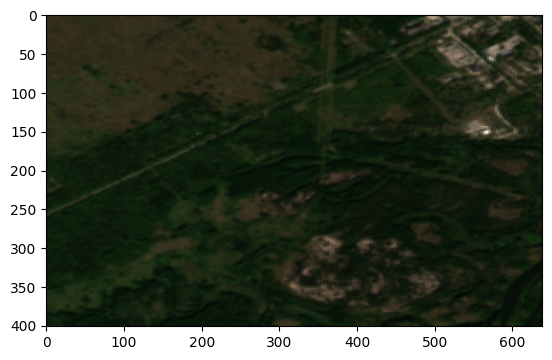

In [18]:
pipeline.plot_image('random_places_9_0.tif', path_folder='data/train', brightness=1)